<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

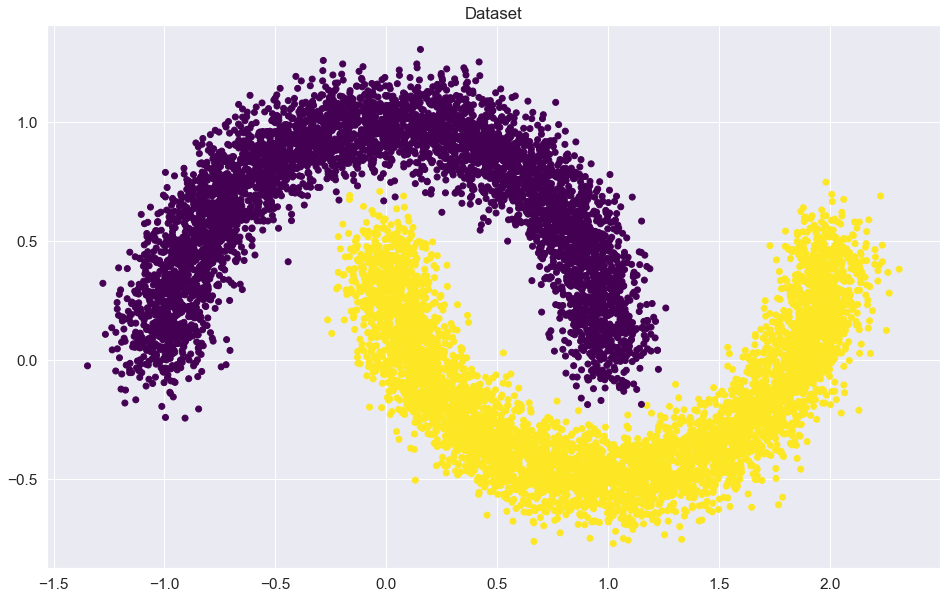

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t = torch.from_numpy(X_train).float()
y_train_t =  torch.from_numpy(y_train).float()
X_val_t =  torch.from_numpy(X_val).float()
y_val_t = torch.from_numpy(y_val).float()

Создаем `Dataset` и `DataLoader`.

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features), requires_grad=True)
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(1), requires_grad=True)

    def forward(self, x):
        x =  torch.matmul(x, self.weights)
        if self.bias:
            x += self.bias_term
        return x

In [8]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

/Users/antoneremin/Documents/JupyterNotebooks/python/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

# Ответ на вопрос 1

Количество параметров в модели: 3 -> а именно 2 свободных веса + байес. (см. код ниже)

In [9]:
print(f"Total model parameter numbers: {sum(p.numel() for p in linear_regression.parameters() if p.requires_grad)}")

Total model parameter numbers: 3


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [10]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression.forward(X_batch)# YOUR CODE. Use linear_regression to get outputs
        loss =  loss_function(outp, y_batch) # YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp) # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.3359375
Iteration: 100
Batch accuracy: 0.5546875
Iteration: 200
Batch accuracy: 0.734375
Iteration: 300
Batch accuracy: 0.8046875
Iteration: 400
Batch accuracy: 0.7734375
Iteration: 500
Batch accuracy: 0.8671875
Iteration: 600
Batch accuracy: 0.8359375
Iteration: 700
Batch accuracy: 0.796875
Iteration: 800
Batch accuracy: 0.8125
Iteration: 900
Batch accuracy: 0.8125

Iteration: 936.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

# Ответ на вопрос 2

Потребовалось 759 итераций. См. код выше.

### Визуализируем результаты

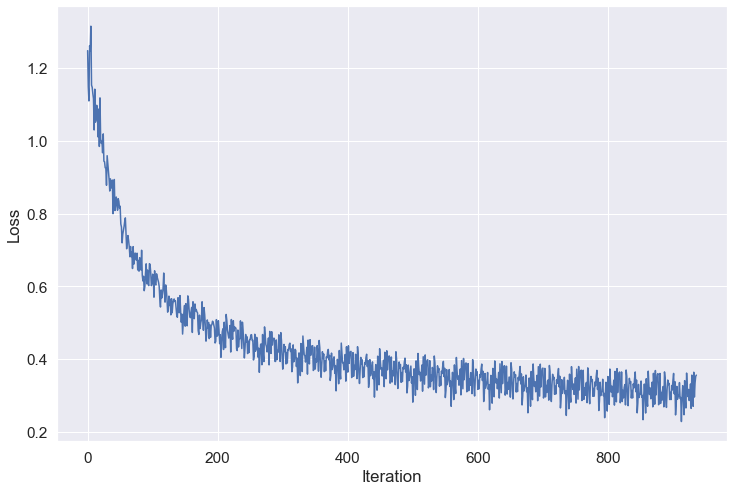

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

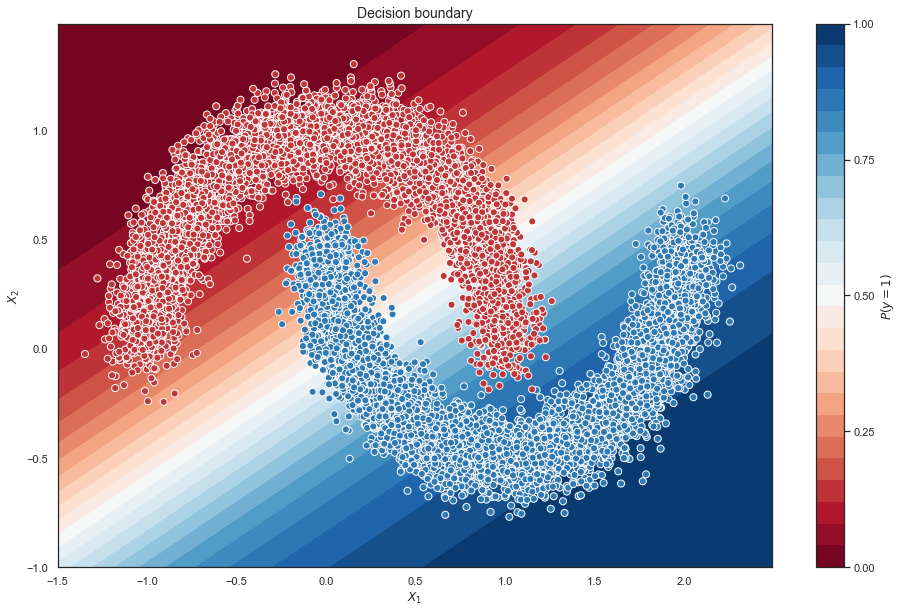

In [12]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [13]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp =  linear_regression.forward(x_batch)
        probabilities = torch.sigmoid(outp) # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [14]:
from sklearn.metrics import accuracy_score

# YOUR CODE. Compute total accuracy
predicted_classes = predict(val_dataloader, linear_regression)

print(accuracy_score(y_true=y_val_t, y_pred=predicted_classes))

0.8556


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:**

# Ответ на вопрос 3

Значение точности получилось: 0.8556

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [15]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=16) # YOUR CODE GOES HERE
valid_dataloader = DataLoader(val_dataset, batch_size=16) # YOUR CODE GOES HERE

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [16]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [17]:
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1*28*28, 128),
    activation,
    nn.Linear(128, 128),
    activation,
    nn.Linear(128, 10)
)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [20]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch.to(device))
            else:
                # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch.to(device))
            preds = outp.argmax(-1)
            correct = sum((preds.cpu().detach() == y_batch).squeeze()) # YOUR CODE GOES HERE
            all = y_batch.size()[0] # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                # YOUR CODE. Calculate gradients and make a step of your optimizer
                loss = criterion(outp, y_batch.to(device))
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9135
Loader: valid. Accuracy: 0.9112
Epoch: 2
Loader: train. Accuracy: 0.9559666666666666
Loader: valid. Accuracy: 0.9192
Epoch: 3
Loader: train. Accuracy: 0.9644333333333334
Loader: valid. Accuracy: 0.9594
Epoch: 4
Loader: train. Accuracy: 0.9715666666666667
Loader: valid. Accuracy: 0.961
Epoch: 5
Loader: train. Accuracy: 0.9755166666666667
Loader: valid. Accuracy: 0.9627
Epoch: 6
Loader: train. Accuracy: 0.9770666666666666
Loader: valid. Accuracy: 0.9593
Epoch: 7
Loader: train. Accuracy: 0.97915
Loader: valid. Accuracy: 0.9623
Epoch: 8
Loader: train. Accuracy: 0.9815833333333334
Loader: valid. Accuracy: 0.9533
Epoch: 9
Loader: train. Accuracy: 0.9811833333333333
Loader: valid. Accuracy: 0.9632
Epoch: 10
Loader: train. Accuracy: 0.9824666666666667
Loader: valid. Accuracy: 0.9649


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [21]:
elu_accuracy = accuracy["valid"]

In [30]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)
def test_activation_function(model, loaders):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    loaders = {"train": train_dataloader, "valid": valid_dataloader}
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch.to(device))
                else:
                    # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch.to(device))
                preds = outp.argmax(-1)
                correct = sum((preds.cpu().detach() == y_batch).squeeze()) # YOUR CODE GOES HERE
                all = y_batch.size()[0] # YOUR CODE GOES HERE
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    # YOUR CODE. Calculate gradients and make a step of your optimizer
                    loss = criterion(outp, y_batch.to(device))
                    loss.backward()
                    optimizer.step()
            accuracy[k].append(epoch_correct/epoch_all)
            
    return accuracy["valid"]

In [31]:
model_plain = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1*28*28, 128),
    Identical(),
    nn.Linear(128, 128),
    Identical(),
    nn.Linear(128, 10)
)

plain_accuracy = test_activation_function(model = model_plain, loaders=loaders)

In [35]:
plain_accuracy

[0.8486,
 0.8805,
 0.8854,
 0.8837,
 0.8811,
 0.8826,
 0.8817,
 0.8849,
 0.8853,
 0.8866]

In [32]:
model_relu = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1*28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

relu_accuracy = test_activation_function(model = model_relu, loaders=loaders)

In [33]:
model_leaky_relu = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1*28*28, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 10)
)

leaky_relu_accuracy = test_activation_function(model = model_leaky_relu, loaders=loaders)

In [34]:
leaky_relu_accuracy

[0.8994, 0.9315, 0.9458, 0.9531, 0.962, 0.9492, 0.9605, 0.9679, 0.9686, 0.9688]

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

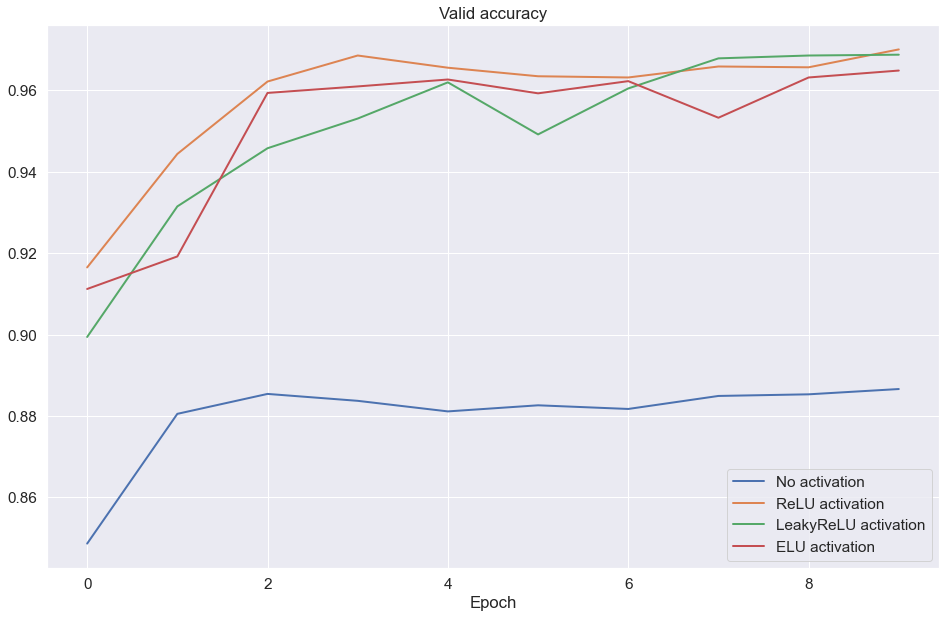

In [36]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

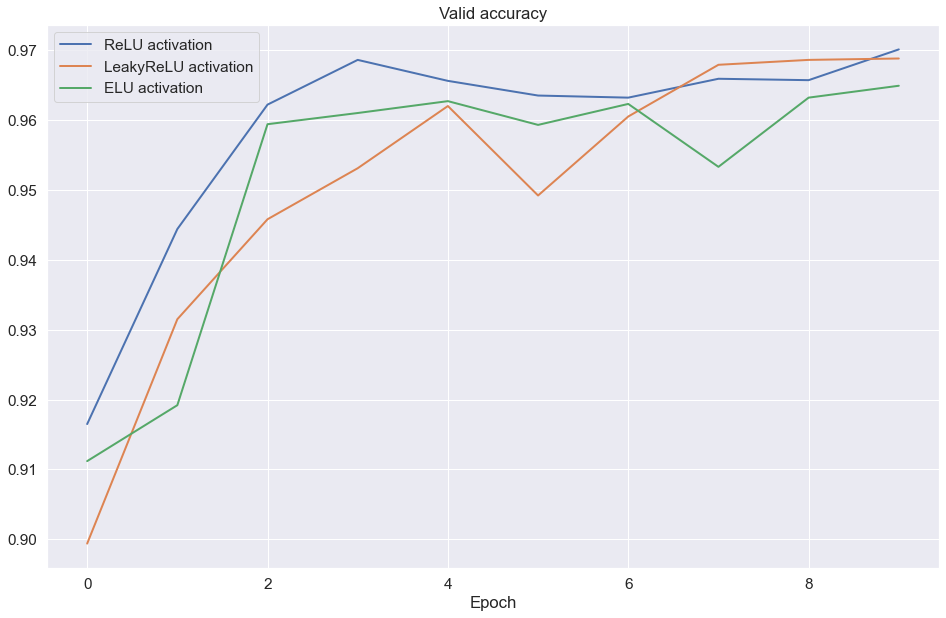

In [37]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [100]:
print(f"Plain accuracy: {plain_accuracy[-1]}")
print(f"ReLU accuracy: {relu_accuracy[-1]}")
print(f"ELU accuracy: {elu_accuracy[-1]}")
print(f"LeakyRELU accuracy: {leaky_relu_accuracy[-1]}")

Plain accuracy: 0.8866
ReLU accuracy: 0.9701
ELU accuracy: 0.9649
LeakyRELU accuracy: 0.9688


**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:**

# Ответ на вопрос 4:

Самой лучшей показала себя активация ReLU.

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [38]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-11-14 15:44:10--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Распознаётся img.the-village.kz (img.the-village.kz)… 5.9.226.237
Подключение к img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 49337 (48K) [image/jpeg]
Сохранение в: «sample_photo.jpg»

sample_photo.jpg    100%[===================>]  48,18K  --.-KB/s    за 0,1s    

2023-11-14 15:44:10 (350 KB/s) - «sample_photo.jpg» сохранён [49337/49337]



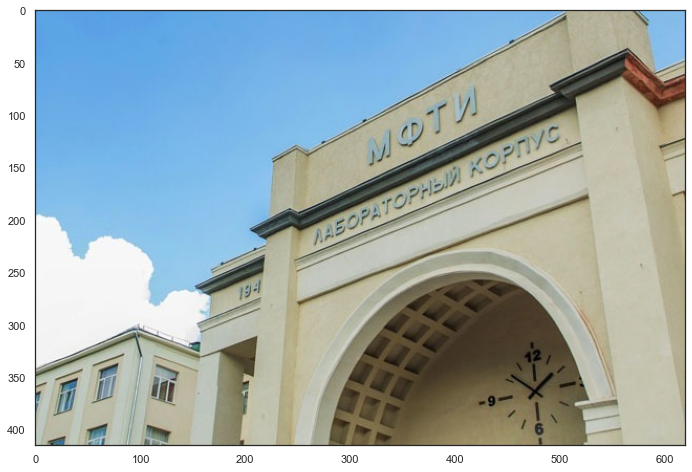

In [39]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте

A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [40]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

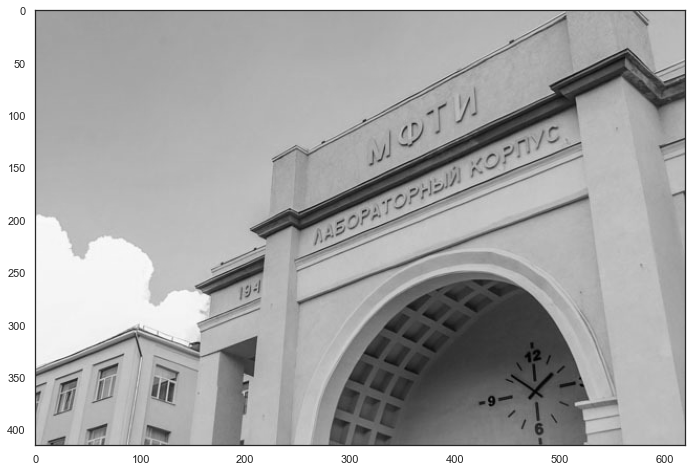

In [41]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0, 0, 0], [0, 1, 0], [0, 0, 0]]
[[0, 1, 0], [0, -2, 0], [0, 1, 0]]
[[0, 0, 0], [1, -2, 1], [0, 0, 0]]
[[0, 1, 0], [1, -4, 1], [0, 1, 0]]
[[0, -1, 0], [-1, 5, -1], [0, -1, 0]]
[[0.0625, 0.125, 0.0625], [0.125, 0.25, 0.125], [0.0625, 0.125, 0.0625]]


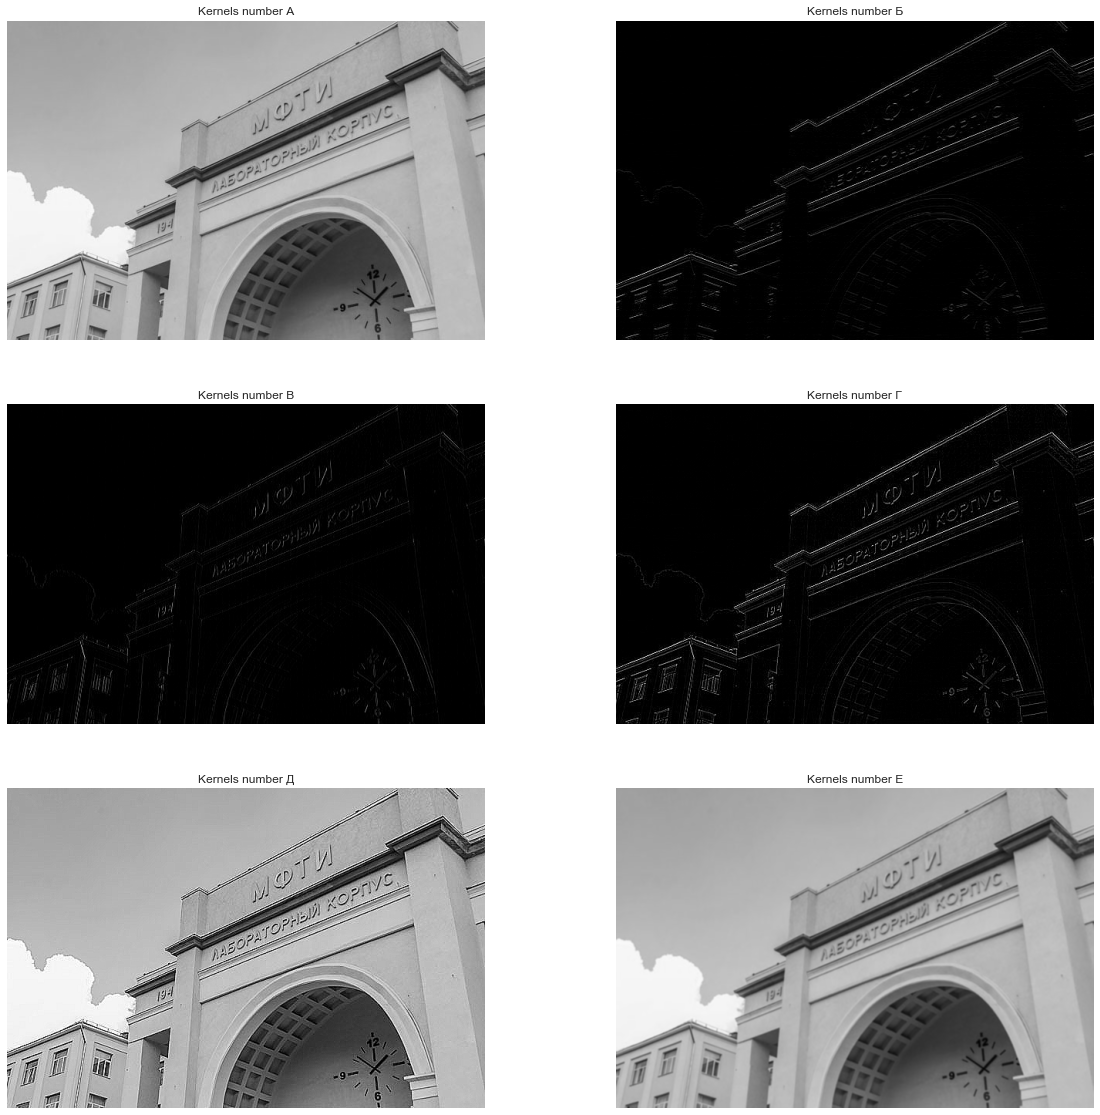

In [42]:
all_kernels = {'А': [[0, 0, 0],[0, 1, 0],[0, 0, 0]],
               'Б': [[0, 1, 0],[0, -2, 0],[0, 1, 0]],
               'В': [[0, 0, 0],[1, -2, 1],[0, 0, 0]],
               'Г': [[0, 1, 0],[1, -4, 1],[0, 1, 0]],
               'Д': [[0, -1, 0],[-1, 5, -1],[0, -1, 0]],
               'Е': [[0.0625, 0.125, 0.0625],[0.125, 0.25, 0.125],[0.0625, 0.125, 0.0625]]}

rows = 3
columns = 2

fig = plt.figure(figsize=(20, 20))

for i in enumerate(all_kernels):
    kernel_matrix = all_kernels[i[1]]
    print(kernel_matrix)
    img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
    kernel = torch.tensor(kernel_matrix).reshape(1, 1, 3, 3).type(torch.float32)
    kernel = kernel.repeat(3, 3, 1, 1)
    img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
    img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size
    result = F.conv2d(img_t, kernel)[0]  #
    result_np = result.permute(1, 2, 0).numpy() / 256 / 3
    
    # Adds a subplot at the 1st position 
    fig.add_subplot(rows, columns, i[0]+1) 

    # showing image 
    plt.imshow(result_np) 
    plt.axis('off') 
    plt.title(f"Kernels number {i[1]}") 
# kernel_visualiser(kernel_a)

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

# Ответ на 5 вопрос

1) Размытие -> **Е**

2) Увеличение резкости -> **Д**

3) Тождественное преобразование -> **А**

4) Выделение вертикальных границ -> **В**

5) Выделение горизонтальных границ -> **Б**

6) Выделение границ -> **Г**


### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [89]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 5 * 5 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [90]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [92]:
lenet_accuracy = test_activation_function(model, loaders)

In [94]:
lenet_accuracy = lenet_accuracy

Сравним с предыдущем пунктом

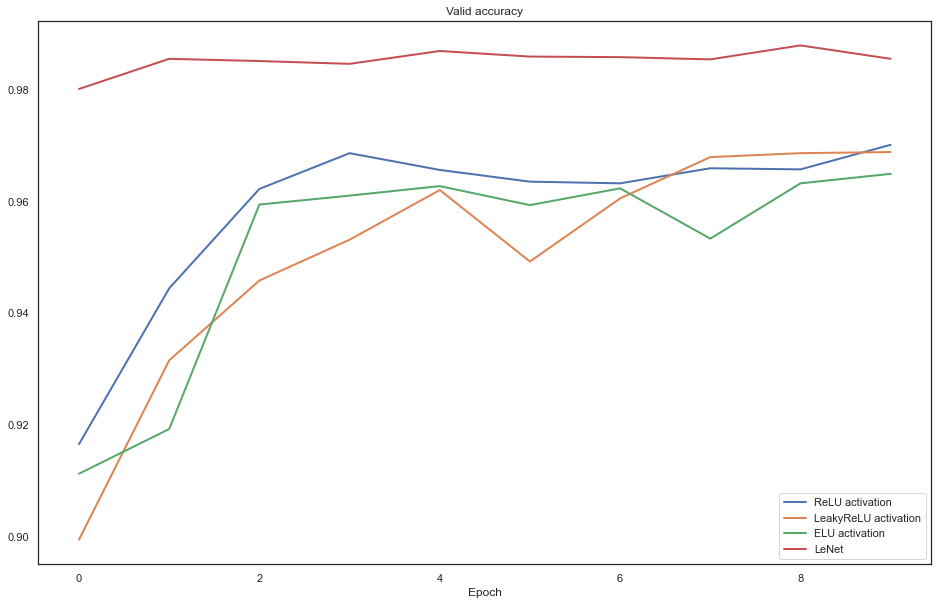

In [96]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**

In [97]:
lenet_accuracy

[0.9801,
 0.9855,
 0.9851,
 0.9846,
 0.9869,
 0.9859,
 0.9858,
 0.9854,
 0.9879,
 0.9855]

# Ответ на вопрос 6

Итоговая точность модели LeNET получилась = 0.98. Для сравнения у модели ReLU было значение 0.9701.